# Stellar Parameter Test
The purpose of this notebook, is to look at the stellar parameter distributions that Scott produced using Ferre and changes in Log g and teff. Using the chi square result, we will generate a probability that we will then use to get our distribution of parameters.

In [1]:
import numpy as np
import corner
import matplotlib.pyplot as plt
from astropy.table import Table
%matplotlib inline

In [2]:
def Gauss_prob(values,mean,sigma):
    '''
    Calculates Gaussain probability at each data point
    
    Arguments:
        values: The data values of interest
        mean: The mean of the Gaussian
        sigma: The sigma of the Gaussian
    Returns:
       A numpy array of probabilities, one for each value.
    '''
    return 1/(sigma*np.sqrt(2*np.pi))*np.exp(-0.5*((values-mean)/sigma)**2)
def get_mean_std(values,chisq):
    '''
    Calculates mean and standard deviation by calculating the expectation value of the mean and variance.
    
    Arguments:
        values: The data values of interest
        chisq: The chi squared of each data value
    Returns:
       The mean and standard deviation
    '''
    lh = np.exp(-chisq/2) #Likelihood
    lh_mean = np.sum(values*lh)
    norm = np.sum(lh)
    mean = lh_mean/norm
    lh_std = np.sum((values-mean)**2*lh)
    std = np.sqrt(lh_std/norm)
    return(mean,std)
def get_mean_std_prior(values,chisq,prior_val,prior_mean,prior_std):
    '''
    Calculates mean and standard deviation by calculating the expectation value of the mean and variance.
    It includes a Gaussian prior.
    
    Arguments:
        values: The data values of interest
        chisq: The chi squared of each data value
        prior_val: The values array for the X_i to be used for the Gaussian prior
        prior_mean: The Gaussian Prior on the mean (X_0)
        prior_std: The Gaussian Prior Standard Deviation Sigma_X.
    Returns:
        The mean and standard deviation
    '''
    #Likliehood and Gaussian Prior
    lh_prior = np.exp(-chisq/2)*np.exp(-0.5*((prior_val-prior_mean)**2)/prior_std**2) 
    lh_prior_mean = np.sum(values*lh_prior)
    norm = np.sum(lh_prior)
    mean = lh_prior_mean/norm
    lh_prior_std = np.sum((values-mean)**2*lh_prior)
    std = np.sqrt(lh_prior_std/norm)
    return(mean,std)
def get_posterior(values,chisq,num_bins):
    '''
    Calculates the posterior probability distribution as a function of the values and chi-squared.
    
    Arguments:
        values: The data values of interest
        chisq: The chi squared of each values value
        numbins: The bining you want to use. I generally default to the number of grid points.
    Returns:
       Tuple (prob_arr,bin_center)
       prob_arr: The probability array
       bin_center: The center of each bin the probability array represents
    '''
    #I assume equal space gridding
    hist,bin_edges = np.histogram(values,num_bins)
    prob_idx = np.digitize(values,bin_edges)
    lh_prob = np.exp(-chisq/2)
    norm = np.sum(lh_prob)
    lh_prob = lh_prob/norm
    prob = list()
    for i in range(len(hist)):
        prob.append(np.sum(lh_prob[(prob_idx-1 == i)])) #digitize returns the 
    prob_arr = np.array(prob)
    bin_center = (bin_edges[1:] - bin_edges[0:-1]) / 2 + bin_edges[0:-1]
    return(prob_arr,bin_center)
def get_posterior_prior(values,chisq,prior_val,prior_mean,prior_std,num_bins):
    '''
    Calculates the posterior probability distribution as a function of the values and chi-squared.
    
    Arguments:
        values: The data values of interest
        chisq: The chi squared of each values value
        prior_val: The values array for the X_i to be used for the Gaussian prior
        prior_mean: The Gaussian Prior on the mean (X_0)
        prior_std: The Gaussian Prior Standard Deviation Sigma_X.
        numbins: The bining you want to use. I generally default to the number of grid points.
    Returns:
       Tuple (prob_arr,bin_center)
       prob_arr: The probability array
       bin_center: The center of each bin the probability array represents
    '''
    #I assume equal space gridding
    hist,bin_edges = np.histogram(values,num_bins)
    prob_idx = np.digitize(values,bin_edges)
    #Likliehood and Gaussian Prior
    lh_prior_prob = np.exp(-chisq/2)*np.exp(-0.5*((prior_val-prior_mean)**2)/prior_std**2) 
    norm = np.sum(lh_prior_prob)
    lh_prior_prob = lh_prior_prob/norm
    prob = list()
    for i in range(len(hist)):
        prob.append(np.sum(lh_prior_prob[(prob_idx-1 == i)])) #digitize returns the right bin hisogram the left
    prob_arr = np.array(prob)
    bin_center = (bin_edges[1:] - bin_edges[0:-1]) / 2 + bin_edges[0:-1]
    return(prob_arr,bin_center)
def posterior2vals(values,chisq,maxfreq=100):
    '''
    Converts an array of values and Chi-squared into a 1-d array length num with each value appearing at
    the rate given by the probability.
    
    Arguments:
        values: The data values of interest
        chisq: The chi-squared of each data value
        maxfreq: The number of times the most probable set of values appears (Default 100).
    Returns:
        A numpy array of values appearing at a frequency equal to thir probability.
    '''
    lh_prob = np.exp(-chisq/2) #Likliehood given Chi Squared statistic
    norm = np.sum(lh_prob)
    lh_prob = lh_prob/norm
   
    max_prob = np.max(lh_prob)
    
    factor = maxfreq/max_prob
    new_prob = lh_prob*factor
    
    new_values = list()
    for i in range(len(new_prob)):
        number = np.floor(new_prob[i])
        if number > 0:
            new_values.extend(np.repeat(values[i],number))
    new_values_arr = np.array(new_values)
    return(new_values_arr)
def posterior2vals_prior(values,chisq,prior_val,prior_mean,prior_std,maxfreq=100):
    '''
    Converts an array of values and chi-squared into a 1-d array length num with each value appearing at
    the rate given by the probability.
    
    Arguments:
        values: The data values of interest
        chisq: The chi-squared of each data value
        prior_val: The values array for the X_i to be used for the Gaussian prior
        prior_mean: The Gaussian Prior on the mean (X_0)
        prior_std: The Gaussian Prior Standard Deviation Sigma_X.
        maxfreq: The number of times the most probable set of values appears (Default 100).
    Returns:
        A numpy array of values appearing at a frequency equal to thir probability.
    '''
    lh_prob = np.exp(-chisq/2)*np.exp(-0.5*((prior_val-prior_mean)**2
                                        )/prior_std**2) #Likliehood and Gaussian Prior
    norm = np.sum(lh_prob)
    lh_prob = lh_prob/norm
   
    max_prob = np.max(lh_prob)
    
    factor = maxfreq/max_prob
    new_prob = lh_prob*factor
    
    new_values = list()
    for i in range(len(new_prob)):
        number = np.floor(new_prob[i])
        if number > 0:
            new_values.extend(np.repeat(values[i],number))
    new_values_arr = np.array(new_values)
    return(new_values_arr)

In [3]:
fit_tab = Table.read('data/sampling_fit_results.FS3.75.txt',format='csv')
fit_tab['# Teff'].name = 'Teff'
fit_tab = fit_tab[(fit_tab['Teff_corr'] > 0)]
fit_tab

Teff,Teff_corr,logg,logg_corr,vmic,mh,cm,nm,am,nov,nlambda1,log(red_chi2)
float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,float64
4546.058105,4633.5041908,3.06513,2.88038367429,0.170799188899,0.199825,0.007815,0.258857,0.026044,4,7214,0.022194
4616.669434,4703.87625414,2.902542,2.69132793532,0.186016093041,0.229729,-0.025073,0.305752,0.060157,4,7214,0.013151
4518.02002,4605.5611128,2.728179,2.48858032156,0.201763477425,0.185043,-0.130498,0.39654,0.039458,4,7214,0.018956
4551.913086,4639.33933261,3.111508,2.93431160718,0.1663590282,0.202641,0.022093,0.241648,0.025182,4,7214,0.025588
4619.394531,4706.59211806,3.072889,2.88940585347,0.170059508649,0.233095,0.028858,0.250001,0.050296,4,7214,0.01583
4626.904297,4714.07643781,2.974288,2.77475354211,0.179366889423,0.234619,0.000766,0.279185,0.056699,4,7214,0.012895
4528.370605,4615.87662493,2.875833,2.66027090183,0.18846562925,0.191614,-0.069751,0.346578,0.032157,4,7214,0.016217
4599.798828,4687.06281453,3.031011,2.84071054048,0.174036950667,0.222425,0.008171,0.273843,0.047409,4,7214,0.014601
4611.047852,4698.27372058,2.653571,2.4018267031,0.20833100179,0.22051,-0.109531,0.391704,0.082741,4,7214,0.027338


The reduced chisquare from ferre is log10(reduced chi^2)

In [4]:
fit_tab['red_chi2'] = 10**fit_tab['log(red_chi2)']
fit_tab['chi2'] = fit_tab['red_chi2'] * (fit_tab['nlambda1']-fit_tab['nov']+1)
#Keeps my exponetials small. Okay because in both numerator and denominator
fit_tab['chi2'] = fit_tab['chi2'] - np.min(fit_tab['chi2']) + 1 
fit_tab

Teff,Teff_corr,logg,logg_corr,vmic,mh,cm,nm,am,nov,nlambda1,log(red_chi2),red_chi2,chi2
float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,float64,float64,float64
4546.058105,4633.5041908,3.06513,2.88038367429,0.170799188899,0.199825,0.007815,0.258857,0.026044,4,7214,0.022194,1.05243189175,167.068680933
4616.669434,4703.87625414,2.902542,2.69132793532,0.186016093041,0.229729,-0.025073,0.305752,0.060157,4,7214,0.013151,1.03074443804,10.6804522298
4518.02002,4605.5611128,2.728179,2.48858032156,0.201763477425,0.185043,-0.130498,0.39654,0.039458,4,7214,0.018956,1.04461438007,110.696604178
4551.913086,4639.33933261,3.111508,2.93431160718,0.1663590282,0.202641,0.022093,0.241648,0.025182,4,7214,0.025588,1.06068884131,226.609544246
4619.394531,4706.59211806,3.072889,2.88940585347,0.170059508649,0.233095,0.028858,0.250001,0.050296,4,7214,0.01583,1.03712236573,56.6716887786
4626.904297,4714.07643781,2.974288,2.77475354211,0.179366889423,0.234619,0.000766,0.279185,0.056699,4,7214,0.012895,1.03013703262,6.30045177236
4528.370605,4615.87662493,2.875833,2.66027090183,0.18846562925,0.191614,-0.069751,0.346578,0.032157,4,7214,0.016217,1.0380469578,63.3389222538
4599.798828,4687.06281453,3.031011,2.84071054048,0.174036950667,0.222425,0.008171,0.273843,0.047409,4,7214,0.014601,1.03419158574,35.53783433
4611.047852,4698.27372058,2.653571,2.4018267031,0.20833100179,0.22051,-0.109531,0.391704,0.082741,4,7214,0.027338,1.06497153518,257.492049698


Best Fit Values:
   Teff    Teff_corr     logg     logg_corr        vmic         mh        cm       nm       am    nov nlambda1 log(red_chi2)    red_chi2   chi2
--------- ------------ -------- ------------- -------------- -------- --------- -------- -------- --- -------- ------------- ------------- ----
4603.9375 4691.1874626 2.933987 2.72789189229 0.183114388276 0.224871 -0.019963 0.301676 0.053715   4     7214      0.012585 1.02940198176  1.0


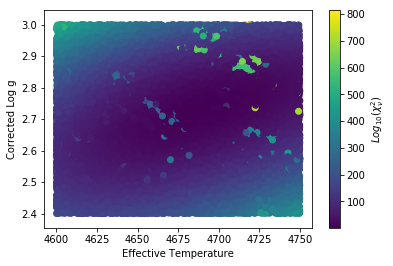

In [5]:
ind = np.argmin(fit_tab['chi2'])
print("Best Fit Values:")
print(fit_tab[ind])
plt.scatter(fit_tab['Teff_corr'],fit_tab['logg_corr'],c=fit_tab['chi2'])
plt.xlabel("Effective Temperature")
plt.ylabel("Corrected Log g")
plt.colorbar(label=r"$Log_{10}(\chi_\nu^2$)")
plt.show()

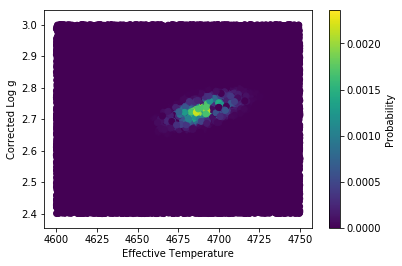

In [6]:
lhprob = np.exp(-fit_tab['chi2']/2)/np.sum(np.exp(-fit_tab['chi2']/2))
plt.scatter(fit_tab['Teff_corr'],fit_tab['logg_corr'],c=lhprob)
plt.xlabel("Effective Temperature")
plt.ylabel("Corrected Log g")
plt.colorbar(label="Probability")
plt.savefig("test_prob.png")
plt.show()

## Deriving Mean and Standard Deviation from probability
* Flat Prior
  * $\chi^2_i$ is the chi squared (not reduced $\chi^2$). I will subtract off the minimum $\chi^2 + 1$ to help 
     keep the exponentials in line. I do the plus 1 to avoid issues with log of 0.
  * Mean: $$<X> = \frac{\sum_i X_i \exp{\frac{-\chi^2_i}{2}}}{\sum_i \exp{\frac{-\chi^2_i}{2}}}$$
  * Variance: $$<(X-<X>)^2> = \frac{\sum_i (X_i-<X>)^2 \exp{\frac{-\chi^2_i}{2}}}{\sum_i \exp{\frac{-\chi^2_i}{2}}}$$
* Gaussian Prior centered on asteroseismic $\log g_0$ with $\sigma_{\log g}$.
$$\exp{\frac{-\chi^2_i}{2}} \rightarrow \exp{\frac{-\chi^2_i}{2}} \exp{\frac{-(\log g_i-\log g_0 )^2}{2(\sigma_{\log g}^2)}}$$
  * $\log g$ prior should be $2.564 \pm 0.01$

## Mean and Std Dev in Log g
With no prior and Log g prior

In [7]:
prior_mean = 2.564
prior_std = 0.01
sample = 200

In [8]:
logg_mean,logg_std = get_mean_std(fit_tab['logg_corr'],fit_tab['chi2'])
print("No Prior Log g: {:.4f} +/- {:.4f}".format(logg_mean,logg_std))
logg_mean_p,logg_std_p = get_mean_std_prior(fit_tab['logg_corr'],fit_tab['chi2'],
                                      fit_tab['logg_corr'],prior_mean,prior_std)
print("With Prior Log g: {:.4f} +/- {:.4f}".format(logg_mean_p,logg_std_p))

No Prior Log g: 2.7278 +/- 0.0255
With Prior Log g: 2.5850 +/- 0.0096


Let's do a plot to see if this makes sense

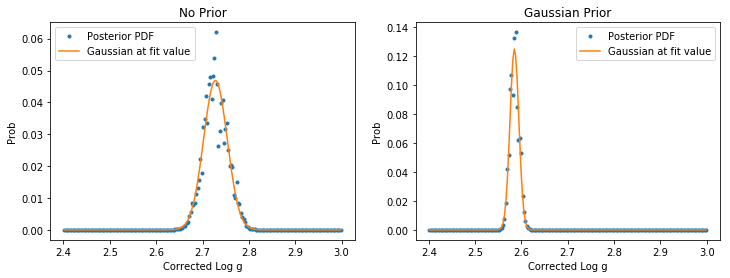

In [9]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
logg_prob,logg_center = get_posterior(fit_tab['logg_corr'],fit_tab['chi2'],sample)
plt.plot(logg_center,logg_prob,'.',label='Posterior PDF')
plt.plot(logg_center,Gauss_prob(logg_center,logg_mean,logg_std)/
         np.sum(Gauss_prob(logg_center,logg_mean,logg_std)),label='Gaussian at fit value')
plt.xlabel("Corrected Log g")
plt.ylabel("Prob")
plt.title("No Prior")
plt.legend()
plt.subplot(1,2,2)
logg_prob,logg_center = get_posterior_prior(fit_tab['logg_corr'],fit_tab['chi2'],
                                      fit_tab['logg_corr'],prior_mean,prior_std,sample)
plt.plot(logg_center,logg_prob,'.',label='Posterior PDF')
plt.plot(logg_center,Gauss_prob(logg_center,logg_mean_p,logg_std_p)/
         np.sum(Gauss_prob(logg_center,logg_mean_p,logg_std_p)),label='Gaussian at fit value')
plt.xlabel("Corrected Log g")
plt.ylabel("Prob")
plt.ylabel("Prob")
plt.legend()
plt.title("Gaussian Prior")
plt.show()

## Mean and Std Dev in Teff
With no prior and Log g prior.

In [10]:
teff_mean,teff_std = get_mean_std(fit_tab['Teff_corr'],fit_tab['chi2'])
print("No Prior Teff: {:.4f} +/- {:.4f}".format(teff_mean,teff_std))
teff_mean_p,teff_std_p = get_mean_std_prior(fit_tab['Teff_corr'],fit_tab['chi2'],
                                      fit_tab['logg_corr'],prior_mean,prior_std)
print("With Prior Teff: {:.4f} +/- {:.4f}".format(teff_mean_p,teff_std_p))

No Prior Teff: 4689.8371 +/- 10.4330
With Prior Teff: 4656.9311 +/- 8.2641


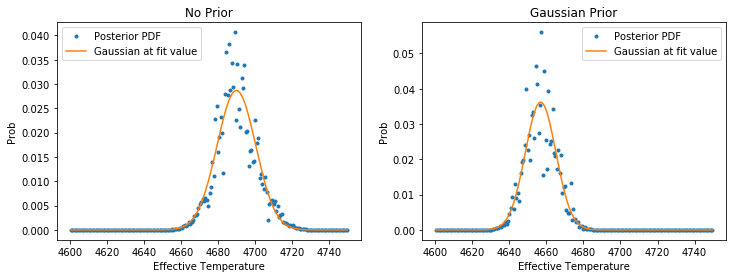

In [11]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
teff_prob,teff_center = get_posterior(fit_tab['Teff_corr'],fit_tab['chi2'],sample)
plt.plot(teff_center,teff_prob,'.',label='Posterior PDF')
plt.plot(teff_center,Gauss_prob(teff_center,teff_mean,teff_std)/
         np.sum(Gauss_prob(teff_center,teff_mean,teff_std)),label='Gaussian at fit value')
plt.xlabel("Effective Temperature")
plt.ylabel("Prob")
plt.title("No Prior")
plt.legend()
plt.subplot(1,2,2)
teff_prob,teff_center = get_posterior_prior(fit_tab['Teff_corr'],fit_tab['chi2'],
                                      fit_tab['logg_corr'],prior_mean,prior_std,sample)
plt.plot(teff_center,teff_prob,'.',label='Posterior PDF')
plt.plot(teff_center,Gauss_prob(teff_center,teff_mean_p,teff_std_p)/
         np.sum(Gauss_prob(teff_center,teff_mean_p,teff_std_p)),label='Gaussian at fit value')
plt.xlabel("Effective Temperature")
plt.ylabel("Prob")
plt.legend()
plt.title("Gaussian Prior")
plt.show()

## Mean and Std Dev in [M/H]
With no prior and Log g prior.

In [12]:
mh_mean,mh_std = get_mean_std(fit_tab['mh'],fit_tab['chi2'])
print("No Prior [M/H]: {:.4f} +/- {:.4f}".format(mh_mean,mh_std))
mh_mean_p,mh_std_p = get_mean_std_prior(fit_tab['mh'],fit_tab['chi2'],
                                      fit_tab['logg_corr'],prior_mean,prior_std)
print("With Prior [M/H]: {:.4f} +/- {:.4f}".format(mh_mean_p,mh_std_p))

No Prior [M/H]: 0.2243 +/- 0.0047
With Prior [M/H]: 0.2095 +/- 0.0039


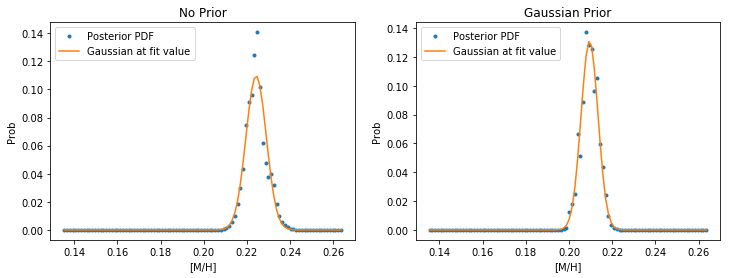

In [13]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
mh_prob,mh_center = get_posterior(fit_tab['mh'],fit_tab['chi2'],sample//2)
plt.plot(mh_center,mh_prob,'.',label='Posterior PDF')
plt.plot(mh_center,Gauss_prob(mh_center,mh_mean,mh_std)/
         np.sum(Gauss_prob(mh_center,mh_mean,mh_std)),label='Gaussian at fit value')
plt.xlabel("[M/H]")
plt.ylabel("Prob")
plt.title("No Prior")
plt.legend()
plt.subplot(1,2,2)
mh_prob,mh_center = get_posterior_prior(fit_tab['mh'],fit_tab['chi2'],
                                      fit_tab['logg_corr'],prior_mean,prior_std,sample//2)
plt.plot(mh_center,mh_prob,'.',label='Posterior PDF')
plt.plot(mh_center,Gauss_prob(mh_center,mh_mean_p,mh_std_p)/
         np.sum(Gauss_prob(mh_center,mh_mean_p,mh_std_p)),label='Gaussian at fit value')
plt.xlabel("[M/H]")
plt.ylabel("Prob")
plt.legend()
plt.title("Gaussian Prior")
plt.show()

## Mean and Std Dev in [C/M]
With no prior and Log g prior.

In [14]:
cm_mean,cm_std = get_mean_std(fit_tab['cm'],fit_tab['chi2'])
print("No Prior [C/M]: {:.4f} +/- {:.4f}".format(cm_mean,cm_std))
cm_mean_p,cm_std_p = get_mean_std_prior(fit_tab['cm'],fit_tab['chi2'],
                                      fit_tab['logg_corr'],prior_mean,prior_std)
print("With Prior [C/M]: {:.4f} +/- {:.4f}".format(cm_mean_p,cm_std_p))

No Prior [C/M]: -0.0218 +/- 0.0114
With Prior [C/M]: -0.0822 +/- 0.0063


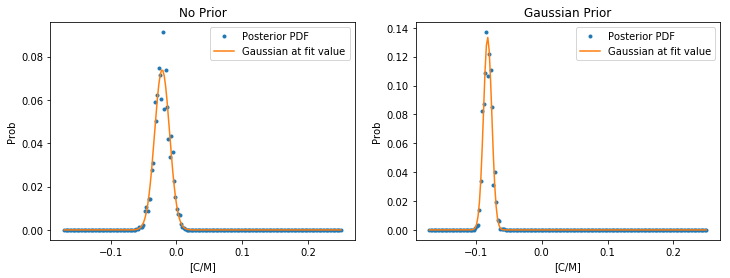

In [15]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
cm_prob,cm_center = get_posterior(fit_tab['cm'],fit_tab['chi2'],sample)
plt.plot(cm_center,cm_prob,'.',label='Posterior PDF')
plt.plot(cm_center,Gauss_prob(cm_center,cm_mean,cm_std)/
         np.sum(Gauss_prob(cm_center,cm_mean,cm_std)),label='Gaussian at fit value')
plt.xlabel("[C/M]")
plt.ylabel("Prob")
plt.title("No Prior")
plt.legend()
plt.subplot(1,2,2)
cm_prob,cm_center = get_posterior_prior(fit_tab['cm'],fit_tab['chi2'],
                                      fit_tab['logg_corr'],prior_mean,prior_std,sample)
plt.plot(cm_center,cm_prob,'.',label='Posterior PDF')
plt.plot(cm_center,Gauss_prob(cm_center,cm_mean_p,cm_std_p)/
         np.sum(Gauss_prob(cm_center,cm_mean_p,cm_std_p)),label='Gaussian at fit value')
plt.xlabel("[C/M]")
plt.ylabel("Prob")
plt.legend()
plt.title("Gaussian Prior")
plt.show()

## Mean and Std Dev in [N/M]
With no prior and Log g prior.

In [16]:
nm_mean,nm_std = get_mean_std(fit_tab['nm'],fit_tab['chi2'])
print("No Prior [N/M]: {:.4f} +/- {:.4f}".format(nm_mean,nm_std))
nm_mean_p,nm_std_p = get_mean_std_prior(fit_tab['nm'],fit_tab['chi2'],
                                      fit_tab['logg_corr'],prior_mean,prior_std)
print("With Prior [N/M]: {:.4f} +/- {:.4f}".format(nm_mean_p,nm_std_p))

No Prior [N/M]: 0.3042 +/- 0.0128
With Prior [N/M]: 0.3636 +/- 0.0071


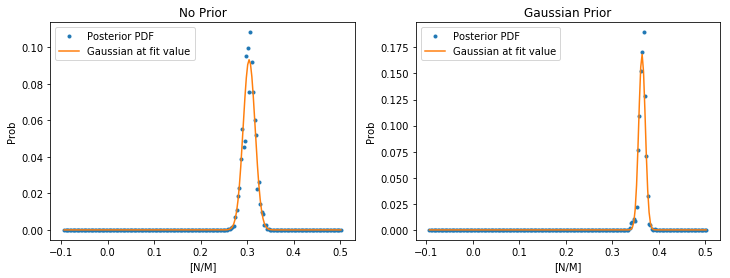

In [17]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
nm_prob,nm_center = get_posterior(fit_tab['nm'],fit_tab['chi2'],sample)
plt.plot(nm_center,nm_prob,'.',label='Posterior PDF')
plt.plot(nm_center,Gauss_prob(nm_center,nm_mean,nm_std)/
         np.sum(Gauss_prob(nm_center,nm_mean,nm_std)),label='Gaussian at fit value')
plt.xlabel("[N/M]")
plt.ylabel("Prob")
plt.title("No Prior")
plt.legend()
plt.subplot(1,2,2)
nm_prob,nm_center = get_posterior_prior(fit_tab['nm'],fit_tab['chi2'],
                                      fit_tab['logg_corr'],prior_mean,prior_std,sample)
plt.plot(nm_center,nm_prob,'.',label='Posterior PDF')
plt.plot(nm_center,Gauss_prob(nm_center,nm_mean_p,nm_std_p)/
         np.sum(Gauss_prob(nm_center,nm_mean_p,nm_std_p)),label='Gaussian at fit value')
plt.xlabel("[N/M]")
plt.ylabel("Prob")
plt.legend()
plt.title("Gaussian Prior")
plt.show()

## Mean and Std Dev in [$\alpha$/M]
With no prior and Log g prior.

In [18]:
am_mean,am_std = get_mean_std(fit_tab['am'],fit_tab['chi2'])
print("No Prior [alpha/M]: {:.4f} +/- {:.4f}".format(am_mean,am_std))
am_mean_p,am_std_p = get_mean_std_prior(fit_tab['am'],fit_tab['chi2'],
                                      fit_tab['logg_corr'],prior_mean,prior_std)
print("With Prior [alpha/M]: {:.4f} +/- {:.4f}".format(am_mean_p,am_std_p))

No Prior [alpha/M]: 0.0534 +/- 0.0035
With Prior [alpha/M]: 0.0529 +/- 0.0039


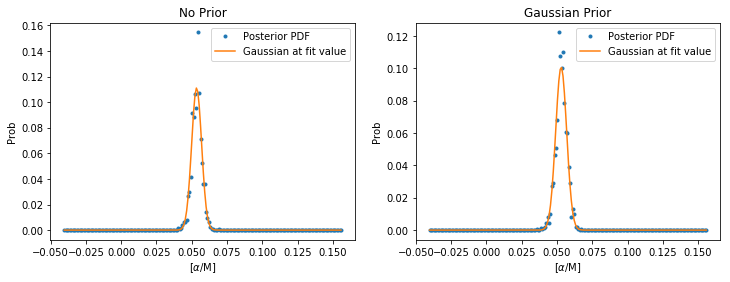

In [19]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
am_prob,am_center = get_posterior(fit_tab['am'],fit_tab['chi2'],sample)
plt.plot(am_center,am_prob,'.',label='Posterior PDF')
plt.plot(am_center,Gauss_prob(am_center,am_mean,am_std)/
         np.sum(Gauss_prob(am_center,am_mean,am_std)),label='Gaussian at fit value')
plt.xlabel(r"[$\alpha$/M]")
plt.ylabel("Prob")
plt.title("No Prior")
plt.legend()
plt.subplot(1,2,2)
am_prob,am_center = get_posterior_prior(fit_tab['am'],fit_tab['chi2'],
                                      fit_tab['logg_corr'],prior_mean,prior_std,sample)
plt.plot(am_center,am_prob,'.',label='Posterior PDF')
plt.plot(am_center,Gauss_prob(am_center,am_mean_p,am_std_p)/
         np.sum(Gauss_prob(am_center,am_mean_p,am_std_p)),label='Gaussian at fit value')
plt.xlabel(r"[$\alpha$/M]")
plt.ylabel("Prob")
plt.legend()
plt.title("Gaussian Prior")
plt.show()

## Mean and Std Dev in V microturbulence
With no prior and Log g prior.

In [20]:
vmic_mean,vmic_std = get_mean_std(fit_tab['vmic'],fit_tab['chi2'])
print("No Prior V Micro: {:.4f} +/- {:.4f}".format(vmic_mean,vmic_std))
vmic_mean_p,vmic_std_p = get_mean_std_prior(fit_tab['vmic'],fit_tab['chi2'],
                                      fit_tab['logg_corr'],prior_mean,prior_std)
print("With Prior V Micro: {:.4f} +/- {:.4f}".format(vmic_mean_p,vmic_std_p))

No Prior V Micro: 0.1831 +/- 0.0020
With Prior V Micro: 0.1943 +/- 0.0007


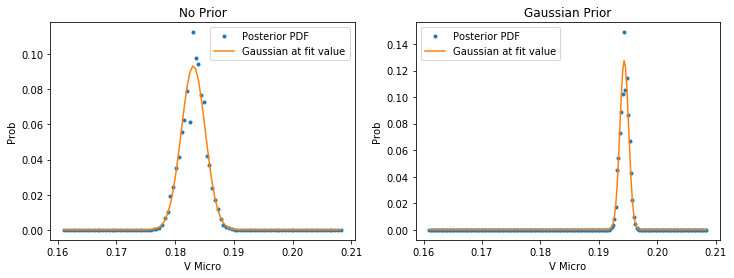

In [21]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
vmic_prob,vmic_center = get_posterior(fit_tab['vmic'],fit_tab['chi2'],sample//2)
plt.plot(vmic_center,vmic_prob,'.',label='Posterior PDF')
plt.plot(vmic_center,Gauss_prob(vmic_center,vmic_mean,vmic_std)/
         np.sum(Gauss_prob(vmic_center,vmic_mean,vmic_std)),label='Gaussian at fit value')
plt.xlabel("V Micro")
plt.ylabel("Prob")
plt.title("No Prior")
plt.legend()
plt.subplot(1,2,2)
vmic_prob,vmic_center = get_posterior_prior(fit_tab['vmic'],fit_tab['chi2'],
                                      fit_tab['logg_corr'],prior_mean,prior_std,sample)
plt.plot(vmic_center,vmic_prob,'.',label='Posterior PDF')
plt.plot(vmic_center,Gauss_prob(vmic_center,vmic_mean_p,vmic_std_p)/
         np.sum(Gauss_prob(vmic_center,vmic_mean_p,vmic_std_p)),label='Gaussian at fit value')
plt.xlabel("V Micro")
plt.ylabel("Prob")
plt.legend()
plt.title("Gaussian Prior")
plt.show()

## Corner Plot (No Prior)

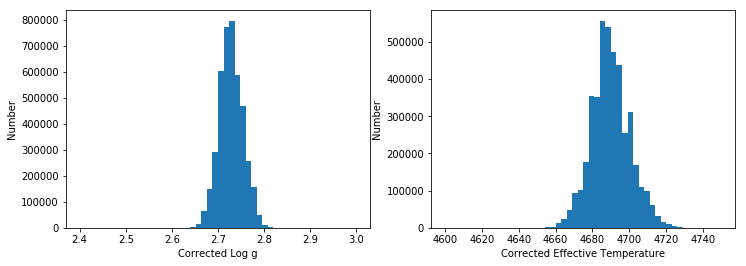

In [22]:
star_num = 10000
logg_trials = posterior2vals(fit_tab['logg_corr'],fit_tab['chi2'],star_num)
teff_trials = posterior2vals(fit_tab['Teff_corr'],fit_tab['chi2'],star_num)
mh_trials = posterior2vals(fit_tab['mh'],fit_tab['chi2'],star_num)
cm_trials = posterior2vals(fit_tab['cm'],fit_tab['chi2'],star_num)
nm_trials = posterior2vals(fit_tab['nm'],fit_tab['chi2'],star_num)
am_trials = posterior2vals(fit_tab['am'],fit_tab['chi2'],star_num)
vmic_trials = posterior2vals(fit_tab['vmic'],fit_tab['chi2'],star_num)

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.hist(logg_trials,50,range=(np.min(fit_tab['logg_corr']),np.max(fit_tab['logg_corr'])))
plt.xlabel("Corrected Log g")
plt.ylabel("Number")
plt.subplot(1,2,2)
plt.hist(teff_trials,50,range=(np.min(fit_tab['Teff_corr']),np.max(fit_tab['Teff_corr'])))
plt.xlabel("Corrected Effective Temperature")
plt.ylabel("Number")
plt.show()

In [23]:
data_comb = np.vstack([logg_trials,teff_trials,mh_trials,cm_trials,nm_trials,am_trials,vmic_trials])
data_comb = data_comb.T
print(data_comb.shape)

(4236148, 7)


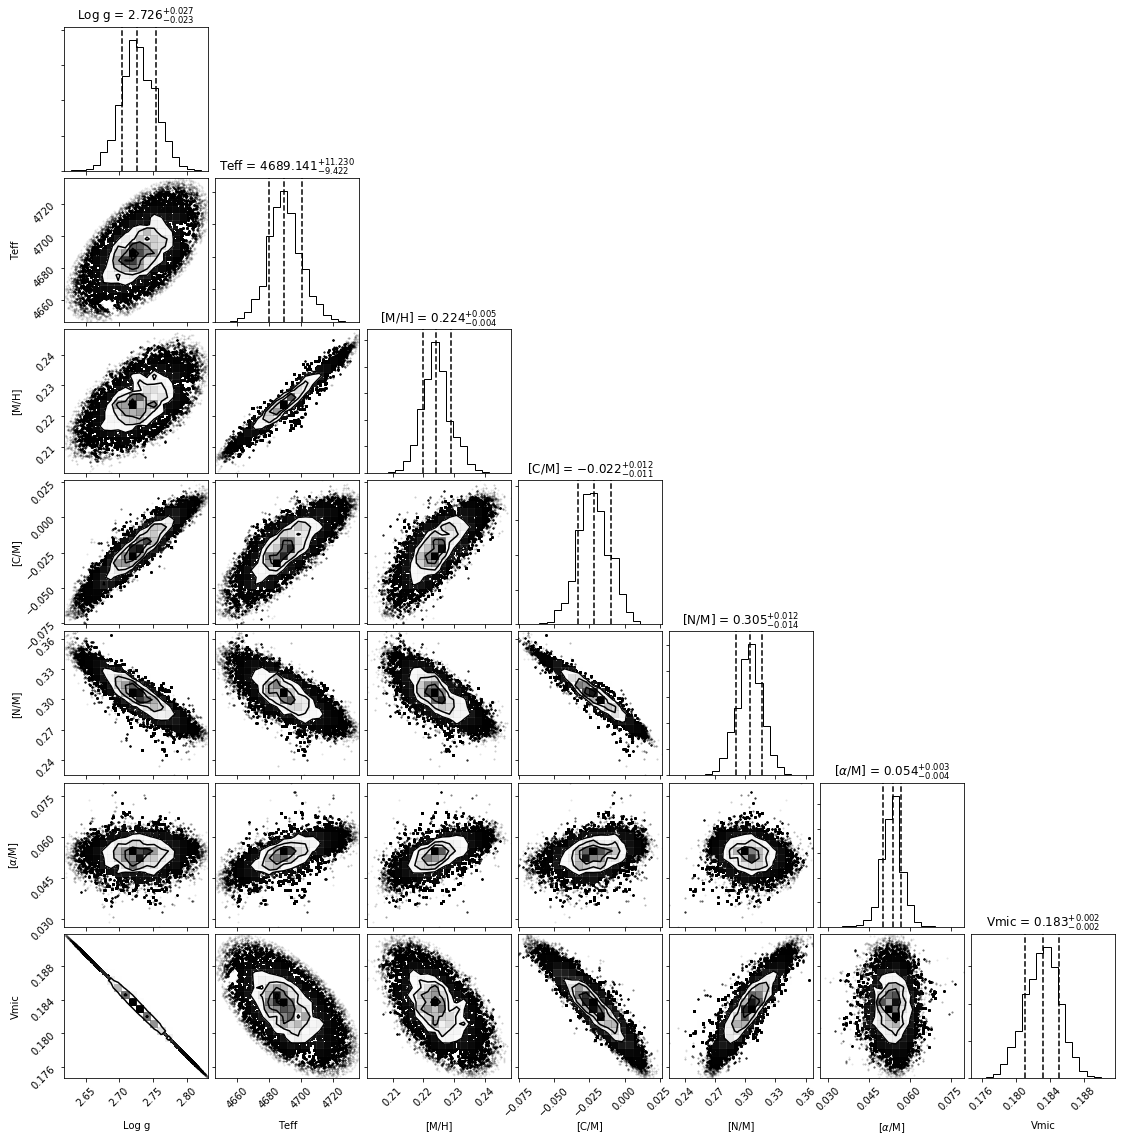

In [24]:
corner.corner(data_comb,labels=[r"Log g", r"Teff", r"[M/H]", r"[C/M]", r"[N/M]", r"[$\alpha$/M]","Vmic"],
                       quantiles=[0.16, 0.5, 0.84],
                       show_titles=True, title_fmt="0.3f",title_kwargs={"fontsize": 12})
plt.show()

## Corner Plot (Gaussian Prior)

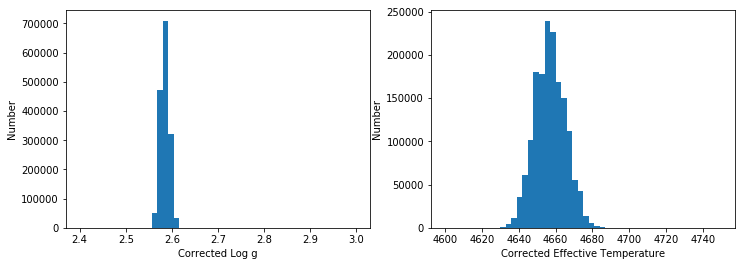

In [25]:
star_num = 10000
logg_trials_p = posterior2vals_prior(fit_tab['logg_corr'],fit_tab['chi2'],fit_tab['logg_corr']
                                     ,prior_mean,prior_std,star_num)
teff_trials_p = posterior2vals_prior(fit_tab['Teff_corr'],fit_tab['chi2'],fit_tab['logg_corr']
                                     ,prior_mean,prior_std,star_num)
mh_trials_p = posterior2vals_prior(fit_tab['mh'],fit_tab['chi2'],fit_tab['logg_corr']
                                     ,prior_mean,prior_std,star_num)
cm_trials_p = posterior2vals_prior(fit_tab['cm'],fit_tab['chi2'],fit_tab['logg_corr']
                                     ,prior_mean,prior_std,star_num)
nm_trials_p = posterior2vals_prior(fit_tab['nm'],fit_tab['chi2'],fit_tab['logg_corr']
                                     ,prior_mean,prior_std,star_num)
am_trials_p = posterior2vals_prior(fit_tab['am'],fit_tab['chi2'],fit_tab['logg_corr']
                                     ,prior_mean,prior_std,star_num)
vmic_trials_p = posterior2vals_prior(fit_tab['vmic'],fit_tab['chi2'],fit_tab['logg_corr']
                                     ,prior_mean,prior_std,star_num)

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.hist(logg_trials_p,50,range=(np.min(fit_tab['logg_corr']),np.max(fit_tab['logg_corr'])))
plt.xlabel("Corrected Log g")
plt.ylabel("Number")
plt.subplot(1,2,2)
plt.hist(teff_trials_p,50,range=(np.min(fit_tab['Teff_corr']),np.max(fit_tab['Teff_corr'])))
plt.xlabel("Corrected Effective Temperature")
plt.ylabel("Number")
plt.show()

In [26]:
data_comb_p = np.vstack([logg_trials_p,teff_trials_p,mh_trials_p,cm_trials_p,nm_trials_p
                         ,am_trials_p,vmic_trials_p])
data_comb_p = data_comb_p.T
print(data_comb_p.shape)

(1591127, 7)


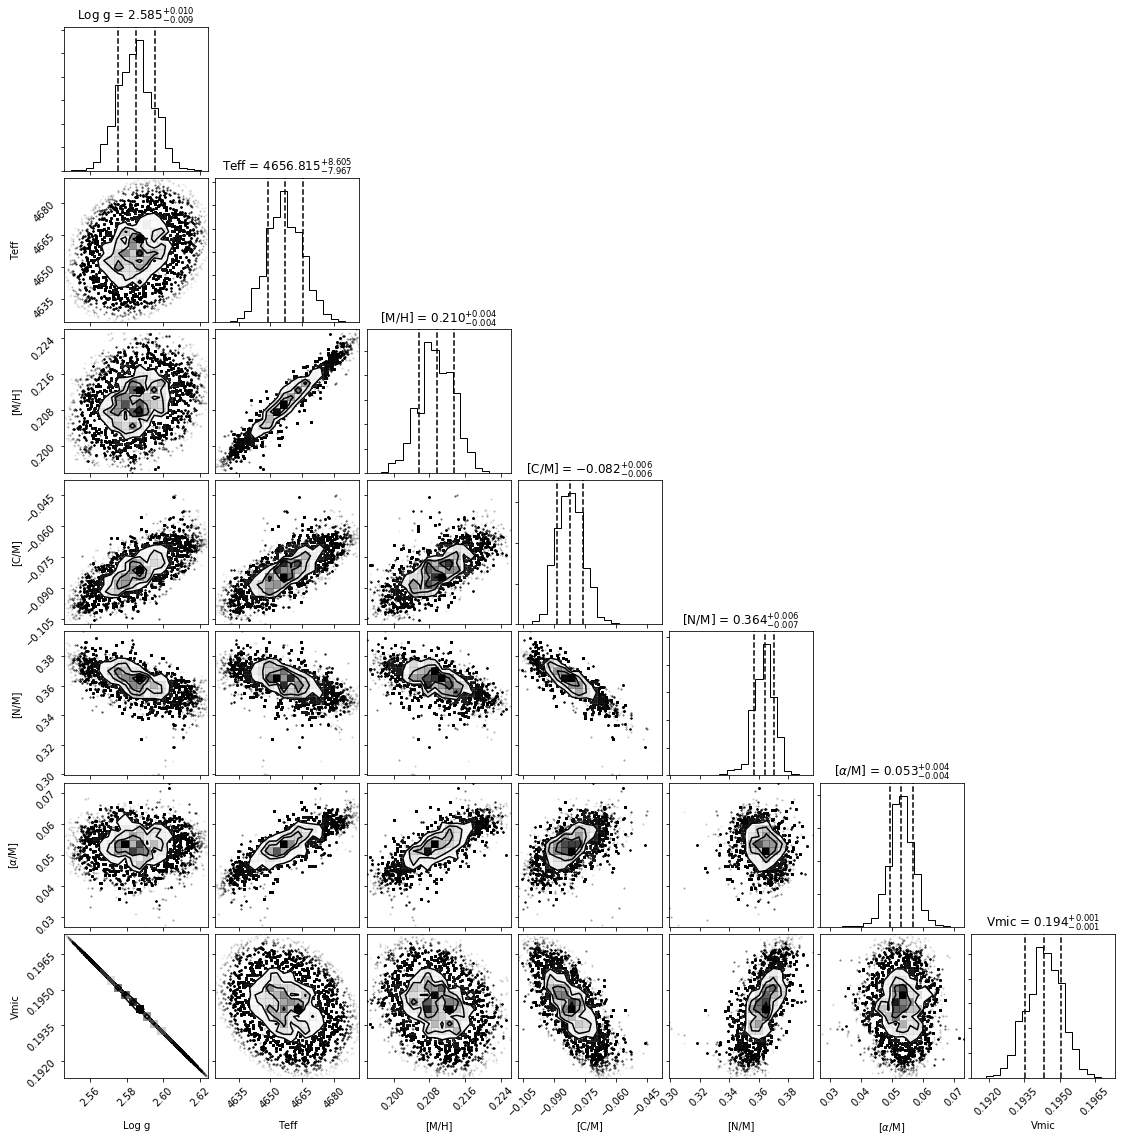

In [27]:
corner.corner(data_comb_p,labels=[r"Log g", r"Teff", r"[M/H]", r"[C/M]", r"[N/M]", r"[$\alpha$/M]","Vmic"],
                       quantiles=[0.16, 0.5, 0.84],
                       show_titles=True, title_fmt="0.3f",title_kwargs={"fontsize": 12})
plt.show()